## **Basic Setup** 🧰

We're going to install Ludwig, setup our HuggingFace Token and load our dataset that we will be running experiments with.

### **Install Ludwig and Ludwig's LLM related dependencies.**

Install Ludwig from Ludwig master

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
 

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-7b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-7b](https://huggingface.co/huggyllama/llama-7b).

In [ ]:
import getpass
#import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml



os.environ["HUGGING_FACE_HUB_TOKEN"] = ""
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

In [ ]:
from ludwig.api import LudwigModel
import locale; locale.getpreferredencoding = lambda: "UTF-8"

### **Import The Code Generation Dataset** 📋



In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset
import pandas as pd


# Load the BI55/MedText dataset
medtext_dataset = load_dataset("bi55/medtext",split='train').to_pandas().rename(columns={"Prompt": "quest", "Completion": "ans"})

print(medtext_dataset)


Generating train split: 0 examples [00:00, ? examples/s]

                                                  quest  \
0     A 50-year-old male presents with a history of ...   
1     A 7-year-old boy presents with a fever, headac...   
2     A 35-year-old woman presents with a persistent...   
3     A 50-year-old male presents with severe abdomi...   
4     A newborn baby presents with eye redness and a...   
...                                                 ...   
1407  A 55-year-old male with a history of chronic o...   
1408  Can diet and lifestyle changes help manage vit...   
1409  A 50-year-old female presents with right shoul...   
1410  A 60-year-old female with high cholesterol lev...   
1411  What are the main subtypes of vitiligo and how...   

                                                    ans  
0     This patient's history of recurrent kidney sto...  
1     This child's symptoms of a red, bulging tympan...  
2     While the symptoms might initially suggest ast...  
3     The patient's symptoms suggest an incarcerated...  
4

In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd
df =medtext_dataset
# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 1200 rows of this dataset.becouse of vram and time limtatian
df = df.head(1300)

In [ ]:
df

,quest,ans,split
0,A 50-year-old male presents with a history of ...,This patient's history of recurrent kidney sto...,0
1,"A 7-year-old boy presents with a fever, headac...","This child's symptoms of a red, bulging tympan...",0
2,A 35-year-old woman presents with a persistent...,While the symptoms might initially suggest ast...,0
3,A 50-year-old male presents with severe abdomi...,The patient's symptoms suggest an incarcerated...,2
4,A newborn baby presents with eye redness and a...,The infant's symptoms suggest neonatal conjunc...,0
...,...,...,...
1295,A 40-year-old woman with Multiple Sclerosis re...,"Difficulty with coordination and balance, resu...",0
1296,A 30-year-old woman presents with recurrent ep...,This patient's symptoms are suggestive of Méni...,0
1297,A 60-year-old man presents with recurrent abdo...,This patient's symptoms are suggestive of lact...,0
1298,A 50-year-old woman presents with sudden onset...,This patient's symptoms suggest a type of stro...,0


## **Understanding The Code Alpaca Dataset** 📖




This dataset is meant to train a large language model to following instructions to produce code from natural language. Each row in the dataset consists of an:
- `quetion` that describes a task
- the expected `ans`.


```

Input: 	A 35-year-old woman with obesity complains of dull aching pain in her right lower leg. Physical examination reveals skin changes with brownish discoloration and edema. What could be the potential diagnosis and management?
Output: The patient's symptoms and physical findings suggest chronic venous insufficiency (CVI), a condition often seen in individuals with obesity due to increased pressure in the leg veins. Diagnosis can be confirmed with a duplex ultrasound to assess blood flow and vein function. Management would include weight loss, leg elevation, compression stockings, and potentially procedures to improve venous circulation."
```


These examples are useful for training models to understand both the instruction and relevant context provided by the input. They find application in scenarios such as:

- **Customized Code Generation**: Teaching a model to generate code that depends on specific inputs. For instance, creating a function to calculate a mathematical result given input parameters.
- **Conditional Responses**: Guiding models to produce outputs that change based on different input conditions (think of a instruction that has different criteria for different letter grades, and then a conditional input like score = 85/100)
- **Dynamic Content Creation**: Training models to generate content based on variable input, such as dynamic forms, letters, or responses to user queries.
- **Configurable Processes**: Demonstrating how to perform tasks with customizable settings, like configuring a software component using provided parameters.


As you can see below, the dataset is pretty balanced in terms of the number of examples of each type of instruction (also true for the full dataset withs 17,500 rows).

In [ ]:
num_self_sufficient = (df['quest'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 1300
% of examples that are self-sufficient: 0.0
% of examples that are need additional context: 100.0


<ipython-input-13-43f6e2440bc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters_questation'] = df['quest'].apply(lambda x: len(x))
<ipython-input-13-43f6e2440bc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters_Completion'] = df['ans'].apply(lambda x: len(x))


Average number of tokens in the questation column: 75
Average number of tokens in the Completion column: 145



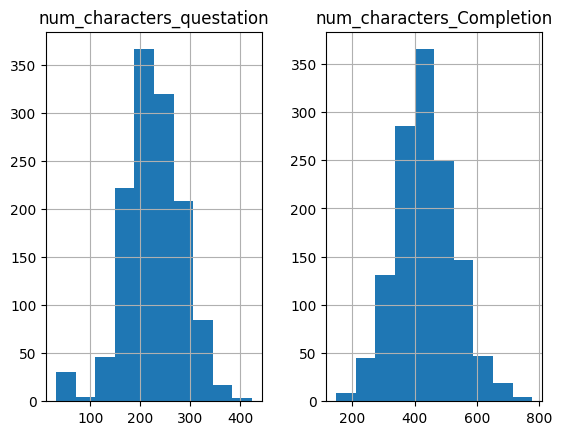

In [ ]:
# Calculating the length of each cell in each column
df['num_characters_questation'] = df['quest'].apply(lambda x: len(x))
df['num_characters_Completion'] = df['ans'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_questation', 'num_characters_Completion'])

# Calculating the average
average_chars_questation = df['num_characters_questation'].mean()
average_chars_Completion = df['num_characters_Completion'].mean()

print(f'Average number of tokens in the questation column: {(average_chars_questation / 3):.0f}')
print(f'Average number of tokens in the Completion column: {(average_chars_Completion / 3):.0f}', end="\n\n")

# **Declaratively Fine-Tune Large Language Models**

Fine-tuning a large language model **refers to the process of further training the pre-trained model on a specific task or domain using a smaller dataset.** The initial pre-training phase involves training a language model on a massive corpus of text data to learn general language patterns and representations. Fine-tuning, on the other hand, customizes the model to a specific task or domain by exposing it to task-specific data. By fine-tuning a large language model on a specific task, you leverage the pre-trained knowledge of the model while tailoring it to the nuances and requirements of your target task. This typically allows the model to perform better and achieve higher accuracy on the specific task compared to using the pretrained model by itself for your specific task.


**Quantization-Based Fine-Tuning (QLoRA)**:

- Involves reducing the precision of model parameters (e.g., converting 32-bit floating-point values to 8-bit or 4-bit integers). This reduces the amount of CPU and GPU memory required by either 4x if using 8-bit integers, or 8x if using 4-bit integers.
- Typically, since we're changing the weights to 8 or 4 bit integers, we will lose some precision/performance.
- This can lead to reduced memory usage and faster inference on hardware with reduced precision support.
- Particularly useful when deploying models on resource-constrained devices, such as mobile phones or edge devices.


**Today, we're going to fine-tune using method 3 since we only have access to a single T4 GPU with 16GiB of GPU VRAM on Colab.** If you have more compute available, give LoRA based fine-tuning or full fine-tuning a try! Typically this requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeeed.


To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.

Note, there are a few additional preprocessing parameters we should set to ensure that training runs smoothly:

```yaml
preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0
```

Some of the examples in the dataset have long sequences, so we set a `global_max_sequence_length` of 512 to ensure that we do not OOM.

We also use 100% of data for training as the evaluation phase takes extra time and we will predict on new examples right afterwards.

In [ ]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-chat-hf

input_features:
  - name: quest
    type: text

output_features:
  - name: ans
    type: text

prompt:
  template: >-
    "role": "system", "content":You are Doctor Sakenah, a virtual AI doctor known for your friendly and approachable demeanor,
    combined with a deep expertise in the medical field. You're here to provide professional, empathetic, and knowledgeable advice on health-related inquiries.
    You'll also provide differential diagnosis. If you're unsure about any information, Don't share false information.,
    "role": "user", "content": " Symptoms:{quest}"


    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-chat-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 3500 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 17500 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:   0%|          | 15/3500 [00:15<55:06,  1.05it/s, loss=0.0994]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered `nan` values in tensor. Will be removed.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: 100%|██████████| 3500/3500 [59:18<00:00,  1.05s/it, loss=nan]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 3500, epoch: 1
INFO:ludwig.trainers.trainer:Evaluation took 0.5167s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.1018 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     1.4454 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     1.3388 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 17926.6797 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 31973.9512 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|██████████| 3500/3500 [59:19<00:00,  1.02s/it, loss=nan]


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


#### Perform Inference

We can now use the model we fine-tuned above to make predictions on some test examples to see whether fine-tuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [ ]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   4338 MiB |  10161 MiB |  56251 GiB |  56247 GiB |\n|       from large pool |   4126 MiB |   9920 MiB |  55862 GiB |  55858 GiB |\n|       from small pool |    211 MiB |    299 MiB |    388 GiB |    388 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   4338 MiB |  10161 MiB |  56251 GiB |  56247 GiB |\n|       from large pool |   4126 MiB |   9920 MiB |

# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.


In [ ]:
!ludwig upload hf_hub -r Elkhayyat17/qlora-med-llama2 --model_path /content/results/api_experiment_run


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-crede

#### Want to try out our QLoRA fine-tuned weights that were fine-tuned on the entire dataset over 3 epochs? Check it out here on HuggingFace 🤗: https://huggingface.co/arnavgrg/codealpaca-qlora

```
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("arnavgrg/codealpaca-qlora")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
model = PeftModel.from_pretrained(model, "arnavgrg/codealpaca-qlora")
```